In [1]:
import torch
#import pytest
import numpy as np
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from utils.heterophilic import get_dataset, get_fixed_splits, WebKB, Actor

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project="sheaf_learning_coboundary_learner")

In [10]:
#here = WebKB('.','texas')

In [10]:
#here.process()

In [11]:
#here.processed_paths

['./texas/processed/data.pt']

In [14]:
dataset = get_dataset('texas')

data = dataset[0]

data = get_fixed_splits(data, 'texas', 0)

data.train_mask.shape

In [15]:
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Callable, Optional

In [16]:

import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


In [17]:
BATCH_SIZE = 1

In [18]:
class SheafDataset_ForGraphs(torch.utils.data.Dataset):
    """It the sheaf"""
    def __init__(self, x_data, label, total_size: int):
        super(SheafDataset_ForGraphs, self).__init__()
        self.x_data = x_data
        self.label  = label
        self.total_size = total_size

    def __len__(self):
        #return self.sheaf_data.size(0)
        # HACKY SOLUTION
        return self.total_size

    def __getitem__(self, index):
        return self.x_data, self.label


In [83]:
class SheafDataModule_ForGraphs(LightningDataModule):
    """docstring for SheafDataModule"""
    def __init__(self, fixed_split, total_size, batch_size :int = BATCH_SIZE):
        super(SheafDataModule_ForGraphs, self).__init__()
        #self.num_types = len(file_dict)
        self.data = fixed_split
        self.batch_size = batch_size
        self.total_size = total_size


    # When doing distributed training, Datamodules have two optional arguments for
    # granular control over download/prepare/splitting data:

    # OPTIONAL, called only on 1 GPU/machine
    #def prepare_data(self):
        #MNIST(os.getcwd(), train=True, download=True)
        #MNIST(os.getcwd(), train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        # transforms
        # split dataset
        #if stage in (None, "fit"):
        #    self.sheaf_train = SheafDataset_ForGraphs(self.data.x[data.train_mask], self.data.y[data.train_mask], self.total_size)
        #    self.sheaf_val = SheafDataset_ForGraphs(self.data.x[data.val_mask], self.data.y[data.val_mask], self.total_size)
        #    #self.sheaf_train, self.sheaf_val = random_split(sheaf_train, [280000, 40000])
        #if stage == "test":
        #    self.sheaf_test = SheafDataset_ForGraphs(self.data.x[data.test_mask], self.data.y[data.test_mask], self.total_size)
        #if stage == "predict":
        #    self.sheaf_predict = SheafDataset_ForGraphs(self.data.x[data.test_mask], self.data.y[data.test_mask], self.total_size)

        if stage in (None, "fit"):
            self.sheaf_train = SheafDataset_ForGraphs(self.data.x, self.data.y, self.total_size)
            self.sheaf_val = SheafDataset_ForGraphs(self.data.x, self.data.y, self.total_size)
            #self.sheaf_train, self.sheaf_val = random_split(sheaf_train, [280000, 40000])
        if stage == "test":
            self.sheaf_test = SheafDataset_ForGraphs(self.data.x, self.data.y ,self.total_size)
        if stage == "predict":
            self.sheaf_predict = SheafDataset_ForGraphs(self.data.x, self.data.y, self.total_size)
    # return the dataloader for each split
    def train_dataloader(self):
        sheaf_train = DataLoader(self.sheaf_train, batch_size=self.batch_size,shuffle=True,num_workers=4)
        return sheaf_train

    def val_dataloader(self):
        sheaf_val = DataLoader(self.sheaf_val, batch_size=self.batch_size,num_workers=4)
        return sheaf_val

    def test_dataloader(self):
        sheaf_test = DataLoader(self.sheaf_test, batch_size=self.batch_size)
        return sheaf_test

    def predict_dataloader(self):
        sheaf_predict = DataLoader(self.sheaf_predict, batch_size=self.batch_size)
        return sheaf_predict


In [84]:
sheaf_dm = SheafDataModule_ForGraphs(data, 20, 1)

In [85]:
sheaf_dm.setup('fit')

In [86]:
a = sheaf_dm.train_dataloader()

In [87]:
for i,batch in enumerate(a):
    batch , _ = batch
    print(i, batch.shape)

0 torch.Size([1, 183, 1703])
1 torch.Size([1, 183, 1703])
2 torch.Size([1, 183, 1703])
3 torch.Size([1, 183, 1703])
4 torch.Size([1, 183, 1703])
5 torch.Size([1, 183, 1703])
6 torch.Size([1, 183, 1703])
7 torch.Size([1, 183, 1703])
8 torch.Size([1, 183, 1703])
9 torch.Size([1, 183, 1703])
10 torch.Size([1, 183, 1703])
11 torch.Size([1, 183, 1703])
12 torch.Size([1, 183, 1703])
13 torch.Size([1, 183, 1703])
14 torch.Size([1, 183, 1703])
15 torch.Size([1, 183, 1703])
16 torch.Size([1, 183, 1703])
17 torch.Size([1, 183, 1703])
18 torch.Size([1, 183, 1703])
19 torch.Size([1, 183, 1703])


In [88]:
type(data)

torch_geometric.data.data.Data

In [89]:
graph = to_networkx(data)

In [90]:
graph

In [91]:
len(graph)

183

In [92]:
graph.number_of_edges()

558

In [93]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [107]:
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
#import torch_sparse

class sheaf_learner(object):
    """docstring for sheaf_learner
        rhop: consider r-hop neighbhorhood for pairwise SPSD matrix
    """
    def __init__(self, arg):
        super(sheaf_learner, self).__init__()
        self.arg = arg

    def cholesky_parametrize(self):

        return None

    #def generate_SPSD(self):





#class coboundary(nn.Module):
#    """docstring for coboundary"""
#    def __init__(self, Ne, Nv, de, dv, edges):
#        super(coboundary, self).__init__()
#        self.coboundary_vector = torch.zeros()
#        self.coboundary_matrix = torch.zeros()

#    def forward(self, x):







class coboundary_learner(pl.LightningModule):
    """docstring for coboundary_learner"""
    def __init__(self, graph, Nv, dv, Ne, de, alpha, beta, learning_rate, true_sheaf = None):
        super(coboundary_learner, self).__init__()
        self.save_hyperparameters()
        self.graph = graph
        self.learning_rate = learning_rate
        #self.backbone = MLP(*modelparams)

        self.Ne = Ne
        self.Nv = Nv
        self.de = de
        self.dv = dv
        self.alpha = alpha
        self.beta  = beta

        # Coboundary maps for vertex where edge is outgoing
        self.coboundary_vec_out = nn.ParameterList([nn.Parameter(torch.randn(de, dv)) for i in range(self.Ne)])

        # Coboundary maps for vertex where edge is coming in
        self.coboundary_vec_in  = nn.ParameterList([nn.Parameter(torch.randn(de, dv)) for i in range(self.Ne)])

        # Lifting graph to a sheaf
        #if do_graph_to_sheaf:
        #    # Later change to a more general backbone
        #    self.graph_to_sheaf = nn.Linear(self.input_dim, self.Nv*self.dv)

        for i in range(self.Ne):
            nn.init.normal_(self.coboundary_vec_out[i])
            nn.init.normal_(self.coboundary_vec_out[i])
            #print(self.coboundary_vec_out[i].size())


    def _common_step(self, batch, batch_idx, stage: str):
        print(batch.size())
        data_covariance = torch.matmul(batch.t(), batch)
        #print(batch.size())
        coboundary = torch.zeros((self.Ne*self.de, self.Nv*self.dv))

        for i, (v1, v2) in enumerate(self.graph.edges):
            coboundary[self.de*i:self.de*(i+1),self.dv*v1:self.dv*(v1+1)] = 1. * self.coboundary_vec_out[i]
            coboundary[self.de*i:self.de*(i+1),self.dv*v2:self.dv*(v2+1)] = -1.* self.coboundary_vec_in[i]

        sheaf_laplacian = torch.matmul(coboundary.t(), coboundary).to(batch)

        # Implement Sparse Matrix Multiplication - torch or torch_sparse
        dirichlet_energy = torch.trace(torch.matmul(data_covariance, sheaf_laplacian))



        reg_connectivity = torch.tensor(0.)
        diagonal_norm = torch.tensor(0.)

        for i in range(self.Nv):
            reg_connectivity = -torch.log(torch.trace(sheaf_laplacian[i*self.dv:(i+1)*self.dv, i*self.dv:(i+1)*self.dv]))
            diagonal_norm = torch.norm(sheaf_laplacian[i*self.dv:(i+1)*self.dv, i*self.dv:(i+1)*self.dv])


        reg_sparsity = torch.norm(sheaf_laplacian) - diagonal_norm
        #print("sparsity: ",reg_sparsity)
        #print("connectivity ", reg_connectivity)
        loss = dirichlet_energy + self.alpha * reg_connectivity + self.beta * reg_sparsity
        return loss


    def calculate_error(self, true_sheaf):

        return torch.norm(self.build_laplacian_from_vector()-true_sheaf)


    def forward(self):

        return self.build_laplacian_from_vector()





    def build_laplacian_from_vector(self):

        coboundary = torch.zeros((self.Ne*self.de, self.Nv*self.dv))

        for i, (v1, v2) in enumerate(self.graph.edges):
            coboundary[self.de*i:self.de*(i+1),self.dv*v1:self.dv*(v1+1)] = 1. * self.coboundary_vec_out[i]
            coboundary[self.de*i:self.de*(i+1),self.dv*v2:self.dv*(v2+1)] = -1.* self.coboundary_vec_in[i]

        sheaf_laplacian = torch.matmul(coboundary.t(), coboundary)

        return sheaf_laplacian

    #def dirichlet_energy(self, x):

    #def regularizer_sparsity(self, x):

    #def regularizer_connectivity(self, x):
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forwardset
        loss = self._common_step(batch, batch_idx, "train")
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        loss = self._common_step(batch, batch_idx, "val")
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):

        loss = self._common_step(batch, batch_idx, "test")
        return loss

    def predict_step(self):
        return self.build_laplacian_from_vector()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer



class coboundary_learner_on_graph_signal(coboundary_learner):
    """docstring for coboundary_learner_on_graph"""
    def __init__(self, graph, Nv, dv, Ne, de, alpha, beta, learning_rate, input_dim, channels, input_dropout, dropout, true_sheaf = None):
        super(coboundary_learner_on_graph_signal, self).__init__(graph, Nv, dv, Ne, de, alpha, beta, learning_rate, true_sheaf = None)
        # Lifting graph to a sheaf
        # Later change to a more general backbone
        # Add Hidden Channel

        self.graph_to_sheaf = nn.Linear(input_dim, self.dv*channels)
        self.graph_to_sheaf2 = nn.Linear(self.dv*channels, self.dv*channels)
        self.input_dropout  = input_dropout
        self.dropout        = dropout


    def _common_step(self, batch, batch_idx, stage: str):
        batch, _  = batch
        #print(batch.size())
        training = False
        if stage == 'train' or 'fit':
            training = True
        batch = F.dropout(batch, p = self.input_dropout, training=training)
        batch = self.graph_to_sheaf(batch)
        batch = F.elu(batch)
        batch = F.dropout(batch, p = self.dropout, training=training)
        batch = self.graph_to_sheaf2(batch)
        #if self.use_act:
        #    x = F.elu(x)
        batch = batch.view(-1, self.Nv * self.dv)


        data_covariance = torch.matmul(batch.t(), batch)
        #print(batch.size())
        coboundary = torch.zeros((self.Ne*self.de, self.Nv*self.dv))

        for i, (v1, v2) in enumerate(self.graph.edges):
            coboundary[self.de*i:self.de*(i+1),self.dv*v1:self.dv*(v1+1)] = 1. * self.coboundary_vec_out[i]
            coboundary[self.de*i:self.de*(i+1),self.dv*v2:self.dv*(v2+1)] = -1.* self.coboundary_vec_in[i]

        sheaf_laplacian = torch.matmul(coboundary.t(), coboundary).to(batch)

        # Implement Sparse Matrix Multiplication - torch or torch_sparse
        dirichlet_energy = torch.trace(torch.matmul(data_covariance, sheaf_laplacian))



        reg_connectivity = torch.tensor(0.)
        diagonal_norm = torch.tensor(0.)

        for i in range(self.Nv):
            reg_connectivity = -torch.log(torch.trace(sheaf_laplacian[i*self.dv:(i+1)*self.dv, i*self.dv:(i+1)*self.dv]))
            diagonal_norm = torch.norm(sheaf_laplacian[i*self.dv:(i+1)*self.dv, i*self.dv:(i+1)*self.dv])


        reg_sparsity = torch.norm(sheaf_laplacian) - diagonal_norm
        #print("sparsity: ",reg_sparsity)
        #print("connectivity ", reg_connectivity)
        loss = dirichlet_energy + self.alpha * reg_connectivity + self.beta * reg_sparsity
        return loss



In [108]:
sheaf_dm = SheafDataModule_ForGraphs(data, 200, 1)

In [109]:
len(graph)

183

In [110]:
graph.number_of_edges()

558

In [111]:
model = coboundary_learner_on_graph_signal( to_networkx(data), len(graph), 2,graph.number_of_edges(), 2, .01, .01, 0.0001,1703, 4,0.1,0.1)

In [112]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=5, verbose=False)

In [113]:

import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


In [114]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/root/projects/temp_checkpoints",
    filename="test-1-sheaflearn-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)

In [115]:
from pytorch_lightning.callbacks import Callback
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")

In [116]:
from pytorch_lightning.callbacks import TQDMProgressBar


In [117]:
torch.cuda.is_available()

True

In [118]:
trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger,auto_lr_find=True)

Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


In [119]:
lr_finder = trainer.tuner.lr_find(model, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_4fb97279-395a-4dbc-81ef-62442081c350.ckpt


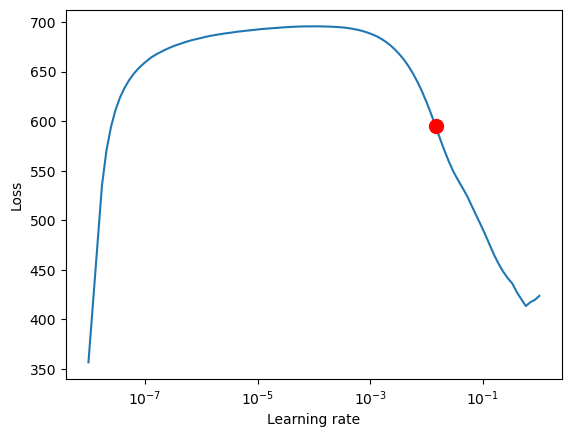

In [120]:


fig = lr_finder.plot(suggest=True)
fig.show()



In [122]:
new_lr = lr_finder.suggestion()

model.hparams.learning_rate = new_lr

model.learning_rate = new_lr

In [123]:
trainer.fit(model, sheaf_dm)

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /root/projects/temp_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type          | Params
----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


In [124]:
model.build_laplacian_from_vector()

tensor([[ 2.3138e-01, -5.0911e-03,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.0911e-03,  1.6431e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  5.6325e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.1679e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          9.0863e+02,  3.0557e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          3.0557e+02,  1.4369e+02]], grad_fn=<MmBackward0>)